In [5]:
%matplotlib inline

import foggie
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.foggie_load import *
#from foggie.satellites.for_paper.central_projection_plots import make_projection_plots
import argparse
from foggie.utils.consistency import *
from numpy import *
from scipy.spatial import geometric_slerp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from yt.units import kpc



def parse_args():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter,
                                     description='''identify satellites in FOGGIE simulations''')
    parser.add_argument('-system', '--system', metavar='system', type=str, action='store', \
                        help='Which system are you on? Default is Jase')
    parser.set_defaults(system="saje")

    parser.add_argument('-simname', '--simname', default=None, help='Simulation to be analyzed.')

    parser.add_argument('-simdir', '--simdir', default='/nobackupp2/mpeeples', help='simulation output directory')

    parser.add_argument('-haloname', '--haloname', default='halo_008508', help='halo_name')

    parser.add_argument('--run', metavar='run', type=str, action='store',
                        help='which run? default is natural')
    parser.set_defaults(run="nref11c_nref9f")

    parser.add_argument('--halo', metavar='halo', type=str, action='store',
                        help='which halo? default is 8508 (Tempest)')
    parser.set_defaults(halo="8508")

    parser.add_argument('--pwd', dest='pwd', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(pwd=False)

    parser.add_argument('--output', metavar='output', type=str, action='store',
                        help='which output? default is RD0020')
    parser.set_defaults(output="RD0027")


    parser.add_argument('--save_dir', metavar='save_dir', type=str, action='store',
                        help='directory to save products')
    parser.set_defaults(save_dir="~")

    parser.add_argument('--use_halo_c_v', dest='use_halo_c_v', action='store_true',
                        help='just use the pwd?, default is no')
    parser.set_defaults(use_halo_c_v=True)

    args = parser.parse_args("")
    return args



In [6]:
args = parse_args()
ds, refine_box = load_sim(args)
sp = ds.sphere(ds.halo_center_kpc, (3, 'kpc'))
bulk_vel = sp.quantities.bulk_velocity().to('km/s')
sp.set_field_parameter('bulk_velocity', bulk_vel)

results = {}
results['L'] = []

results = {}
results['L'] = []

for i in ['x', 'y', 'z']:
    L_gas     = sp.quantities.total_quantity(('gas', 'angular_momentum_%s'%i))
    print (i, L_gas)
    results['L'].append(float(L_gas.to('cm**2*g/s').value))

results['L'] = np.array(results['L'])

L = results['L']/np.sqrt(np.sum(results['L']**2.))


sp_sm = ds.sphere(ds.halo_center_kpc, (100., 'kpc'))
sp_sm.set_field_parameter('bulk_velocity', bulk_vel)

yt : [INFO     ] 2021-03-05 01:20:41,022 Parameters: current_time              = 275.39360046374
yt : [INFO     ] 2021-03-05 01:20:41,023 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-03-05 01:20:41,023 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-03-05 01:20:41,024 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-03-05 01:20:41,024 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-03-05 01:20:41,024 Parameters: current_redshift          = 0.99999995920487
yt : [INFO     ] 2021-03-05 01:20:41,025 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2021-03-05 01:20:41,025 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2021-03-05 01:20:41,026 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-03-05 01:20:41,026 Parameters: hubble_constant           = 0.695
Parsing Hierarchy :   0%|          | 0/5965 [00:00<?, ?it/s]

Opening snapshot /Users/rsimons/Desktop/foggie/sims/halo_008508/nref11c_nref9f/RD0027/RD0027
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.00040804048 0.49149 0.481911 0.503621 0.49349 0.483911 0.505621    9


Parsing Hierarchy : 100%|█████████▉| 5964/5965 [00:00<00:00, 9533.20it/s] 
yt : [INFO     ] 2021-03-05 01:20:41,879 Gathering a field list (this may take a moment.)
yt : [WARNING  ] 2021-03-05 01:20:43,375 The young_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2021-03-05 01:20:43,386 The old_stars particle filter already exists. Overriding.
yt : [WARNING  ] 2021-03-05 01:20:43,397 The stars particle filter already exists. Overriding.
yt : [WARNING  ] 2021-03-05 01:20:43,412 The dm particle filter already exists. Overriding.


Pulling halo center from catalog file
filtering young_stars particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
x -5.416506218359795e+71 cm**2*g/s
y -7.0617588391311205e+71 cm**2*g/s
z -8.813641194927179e+71 cm**2*g/s


In [7]:
temps = [(0., 1.5e4, 'cold', 'darkblue'),
         (1.5e4, 1.e5, 'warm', 'blue'),
         (1.e5, 1.e6, 'warmhot', 'red'),
         (1.e6, 1.e10, 'hot', 'darkred'), 
         (0., 1.e10, 'all', 'black')]

In [47]:
Li = {}
Li_sh = {}
rbins = np.arange(0, 100, 0.5)*kpc

#do gas
for (low_temp, high_temp, name, clr) in temps:
    print (name)
    temp_cut = sp_sm.cut_region(["(obj['temperature'] > {}) & (obj['temperature'] < {})".format(low_temp, high_temp)])
    Li_accum = yt.create_profile(temp_cut, [('gas', 'radius_corrected')],
                                 fields=[('gas', 'angular_momentum_x'), 
                                         ('gas', 'angular_momentum_y'), 
                                         ('gas', 'angular_momentum_z')], 
                                 weight_field=None, accumulation=True,
                                override_bins = {('gas', 'radius_corrected'):rbins})
    Li_shell = yt.create_profile(temp_cut, [('gas', 'radius_corrected')],
                                 fields=[('gas', 'angular_momentum_x'), 
                                         ('gas', 'angular_momentum_y'), 
                                         ('gas', 'angular_momentum_z')], 
                                 weight_field=None, accumulation=False,
                                override_bins = {('gas', 'radius_corrected'):rbins})

    
    Li[name] = np.stack((Li_accum.x, Li_accum[('gas', 'angular_momentum_x')],  
                                     Li_accum[('gas', 'angular_momentum_y')],  
                                     Li_accum[('gas', 'angular_momentum_z')]))
    Li_sh[name] = np.stack((Li_shell.x, Li_shell[('gas', 'angular_momentum_x')], 
                                        Li_shell[('gas', 'angular_momentum_y')],  
                                        Li_shell[('gas', 'angular_momentum_z')]))
    
    
    
for ptype in ['stars', 'dm']:
    print (ptype)
    Li_accum = yt.create_profile(sp_sm, [(ptype, 'particle_radius')],
                                 fields=[(ptype, 'particle_angular_momentum_x'), 
                                         (ptype, 'particle_angular_momentum_y'), 
                                         (ptype, 'particle_angular_momentum_z')], 
                                 weight_field=None, accumulation=True,
                                 override_bins = {(ptype, 'particle_radius'):rbins})
    
    
    Li_shell = yt.create_profile(sp_sm, [(ptype, 'particle_radius')],
                                 fields=[(ptype, 'particle_angular_momentum_x'), 
                                         (ptype, 'particle_angular_momentum_y'), 
                                         (ptype, 'particle_angular_momentum_z')], 
                                 weight_field=None, accumulation=False,
                                 override_bins = {(ptype, 'particle_radius'):rbins})
    
    
    
    
    Li[ptype] = np.stack((Li_accum.x.to('kpc'), Li_accum[(ptype, 'particle_angular_momentum_x')],  
                                        Li_accum[(ptype, 'particle_angular_momentum_y')],  
                                        Li_accum[(ptype, 'particle_angular_momentum_z')]))
    
    
    Li_sh[ptype] = np.stack((Li_shell.x.to('kpc'), Li_shell[(ptype, 'particle_angular_momentum_x')], 
                                                   Li_shell[(ptype, 'particle_angular_momentum_y')],  
                                                   Li_shell[(ptype, 'particle_angular_momentum_z')]))
    
    

cold
warm
warmhot
hot
all
stars
dm


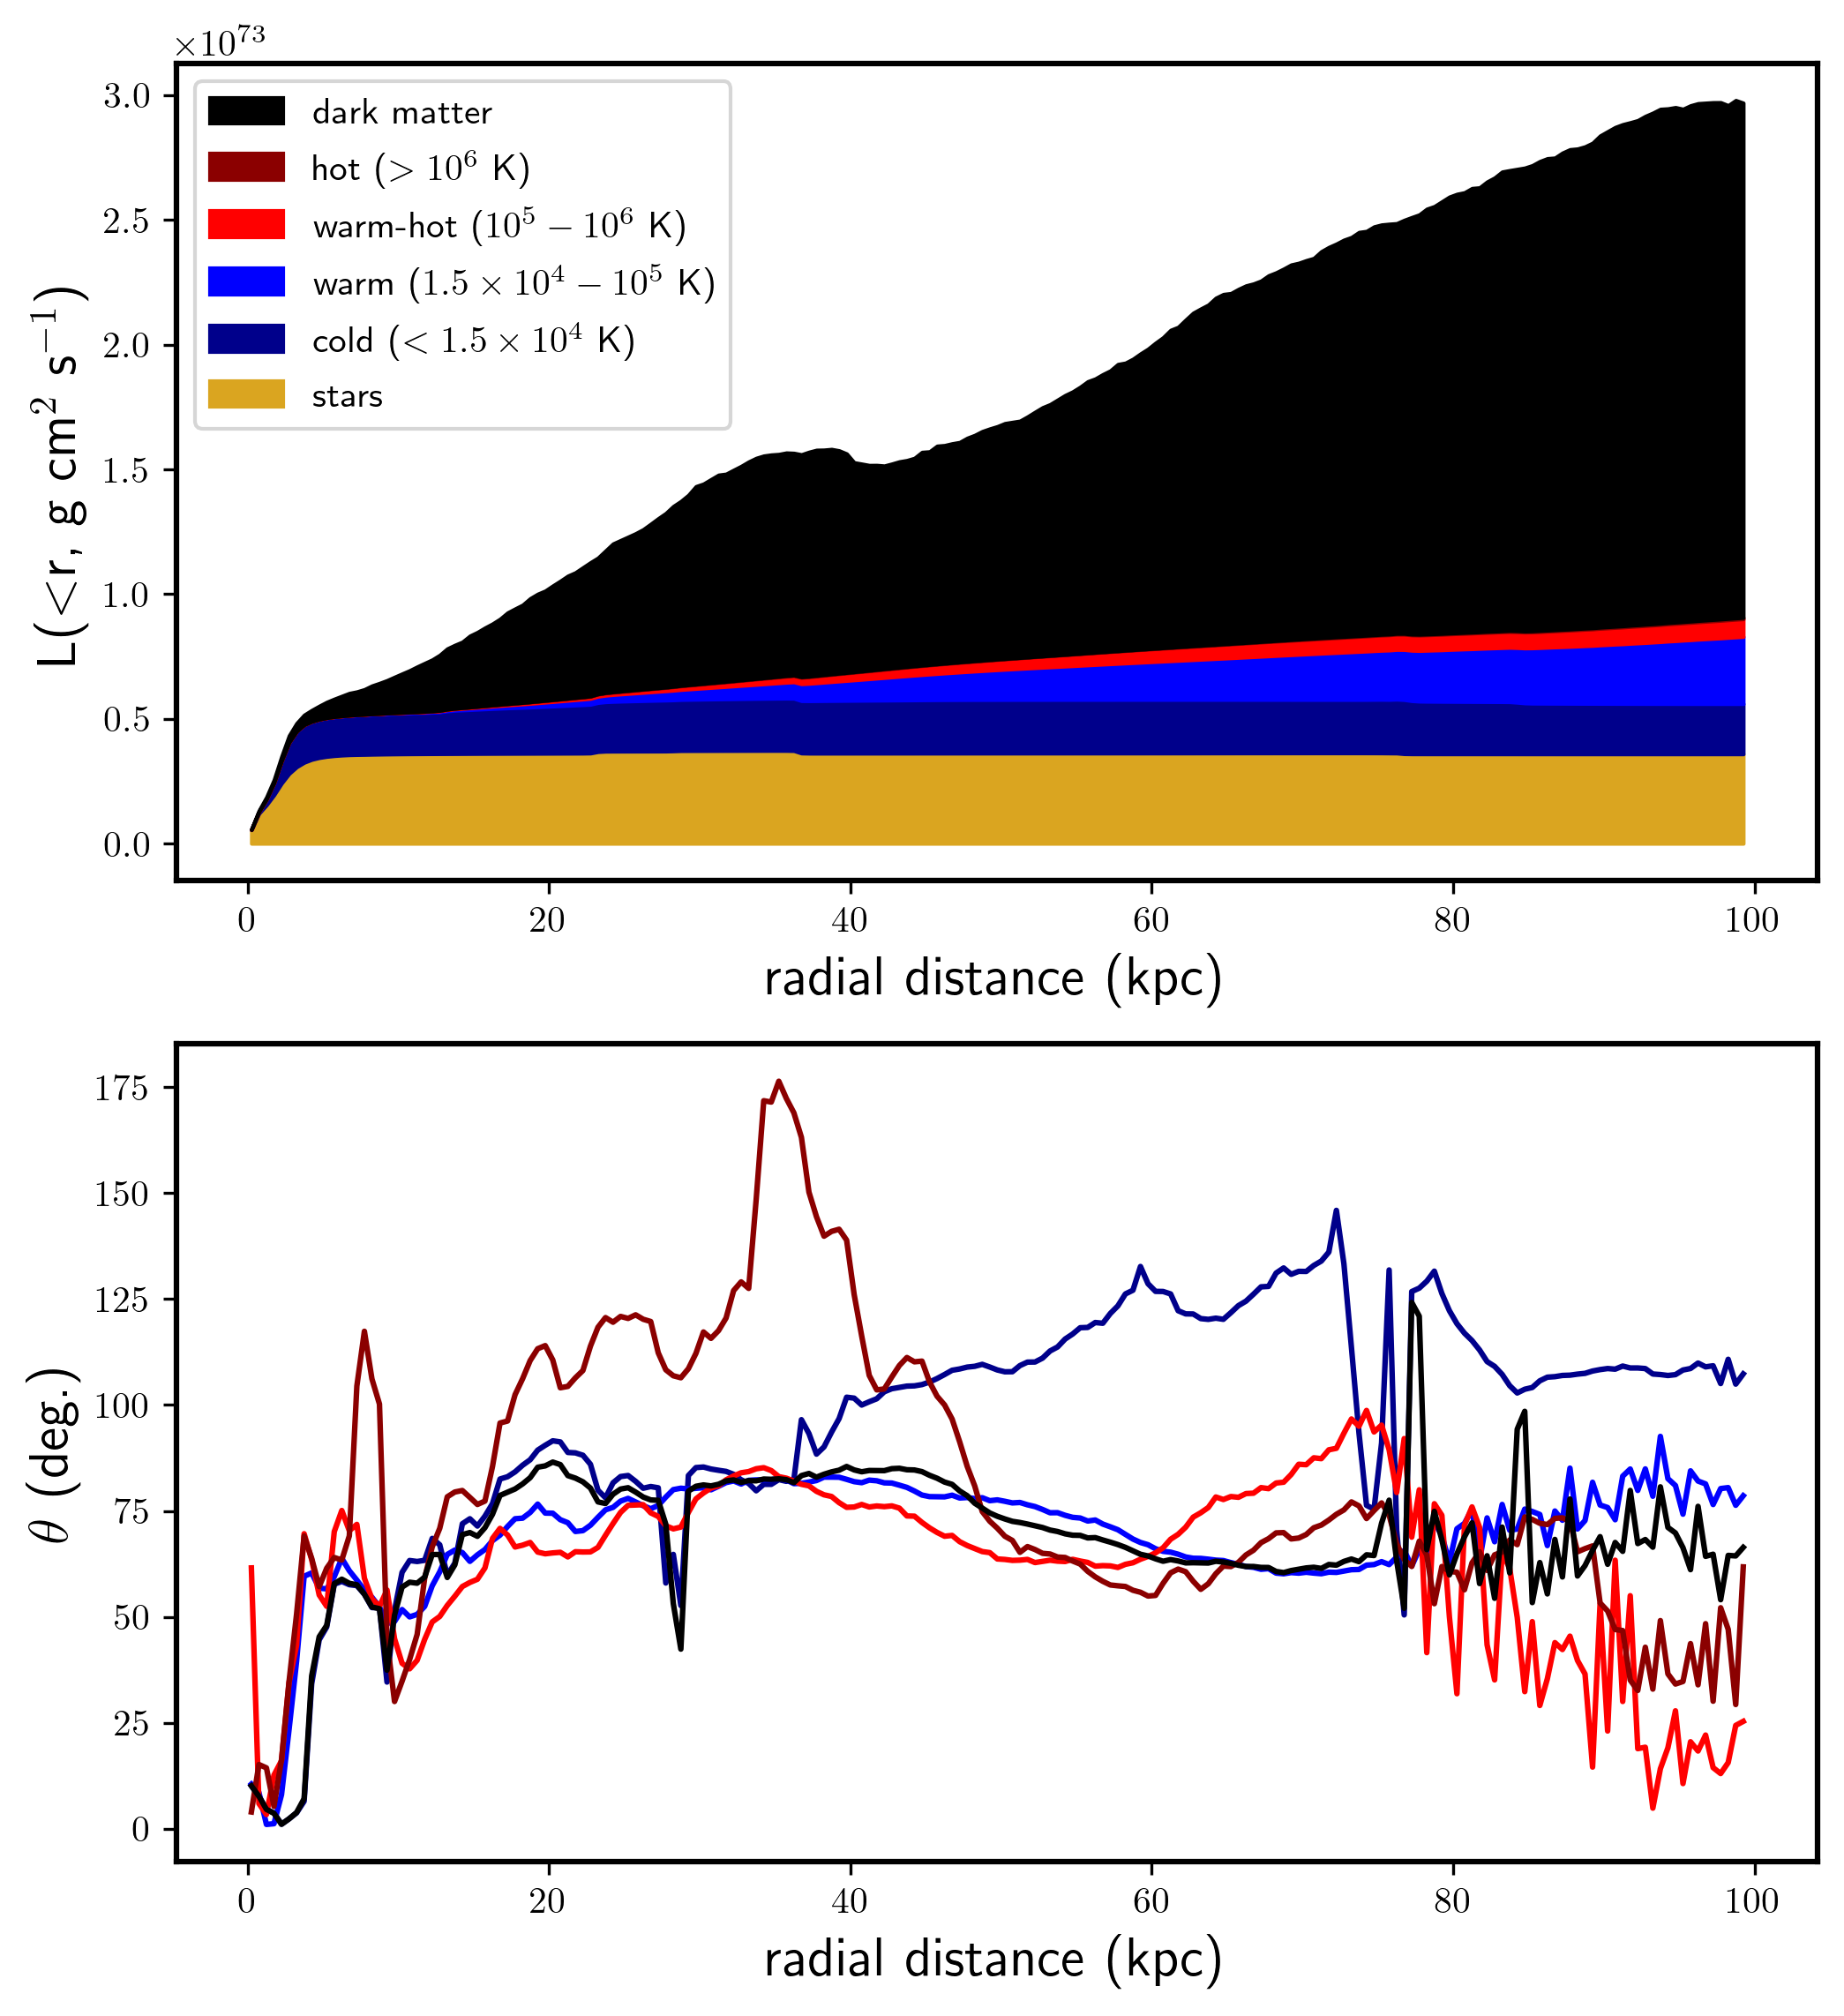

In [110]:
fig, ax = plt.subplots(2,1, figsize = (8,9))


nbins = len(Li[name][0])
y1 = np.zeros(nbins)

def get_lbl_name(name):
    if name == 'hot': lbl_name = 'hot ($>10^6$ K)'
    elif name == 'warmhot': lbl_name = 'warm-hot ($10^5-10^6$ K)'
    elif name == 'warm': lbl_name = r'warm ($1.5\times 10^4-10^5$ K)'
    elif name == 'cold': lbl_name = r'cold ($<1.5\times 10^4$ K)'
    elif name == 'stars': lbl_name = 'stars'
    elif name == 'dm': lbl_name = 'dark matter'
    elif name == 'all': lbl_name = 'all gas'

    return lbl_name


#do particles
for (name, clr) in [('stars', 'goldenrod')]:
    L_accum = np.sqrt(sum(Li[name][1:]**2., axis = 0))
    y2 = y1 + L_accum
    lbl_name = get_lbl_name(name)
    ax[0].fill_between(Li[name][0], y1 = y1, y2 = y2, label = lbl_name, color = clr)
    y1 = y2

#do gas
for (low_temp, high_temp, name, clr) in temps:
    L_accum = np.sqrt(sum(Li[name][1:]**2., axis = 0))
    Li_shell_tot = np.sqrt(sum(Li_sh[name][1:]**2., axis = 0))
    theta = np.arccos(np.array([np.dot(Li_sh[name][1:, i], L)/Li_shell_tot[i] for i in np.arange(len(Li_sh[name][1]))])) * 180./pi
    lbl_name = get_lbl_name(name)

    ax[1].plot(Li_sh[name][0], theta, label = lbl_name, color = clr)
    if name !='all':
        y2 = y1 + L_accum
        ax[0].fill_between(Li[name][0], y1 = y1, y2 = y2, label = lbl_name, color = clr)
        y1 = y2


#do particles
if True:
    for (name, clr) in [ ('dm', 'black')]:
        L_accum = np.sqrt(sum(Li[name][1:]**2., axis = 0))
        y2 = y1 + L_accum
        lbl_name = get_lbl_name(name)

        ax[0].fill_between(Li[name][0], y1 = y1, y2 = y2, label = lbl_name, color = clr)
        y1 = y2


    
for a in ax:
    a.set_xlabel('radial distance (kpc)')

ax[0].set_ylabel('L($<$r, g cm$^2$ s$^{-1}$)')
ax[1].set_ylabel(r'$\theta$ (deg.)')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1],loc = 2)
fig.set_dpi(300)


<ipython-input-220-7c9d2e88a1b5>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


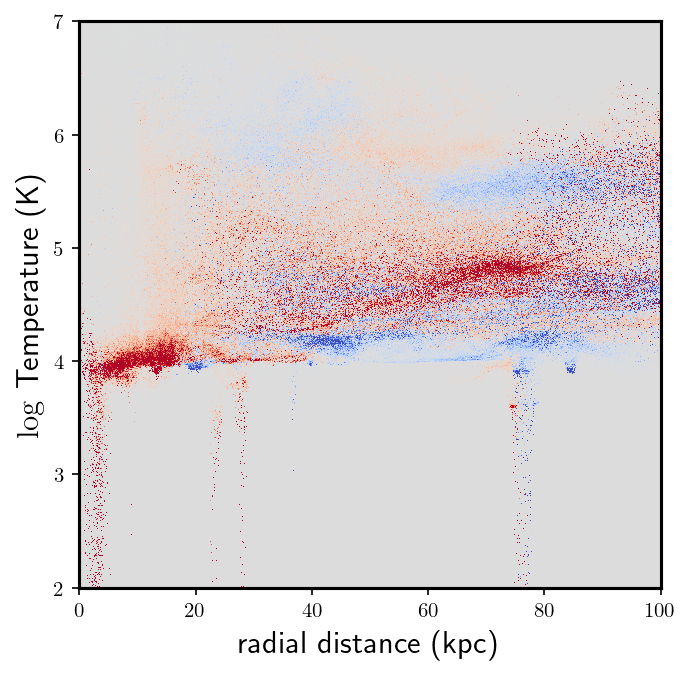

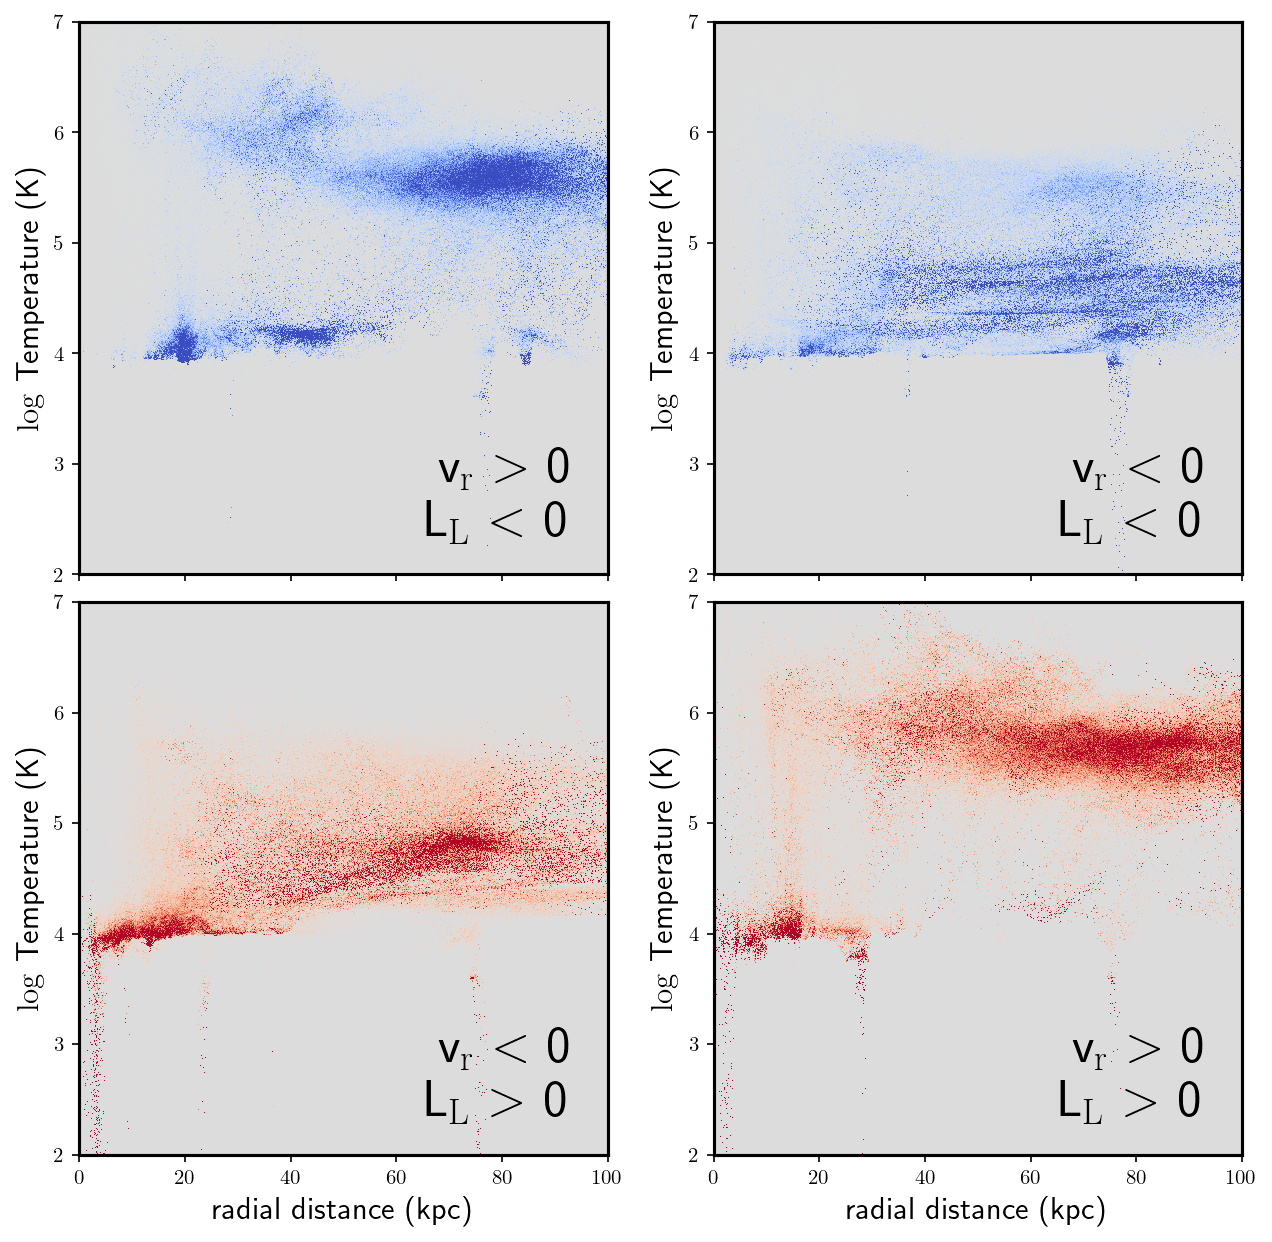

In [220]:
plt.close('all')
fig1, ax1 = plt.subplots(1,1, figsize = (5, 5))
fig, axes = plt.subplots(2,2, figsize = (10, 10))
#fig2, ax2 = plt.subplots(1,1, figsize = (10, 5))

#gd = abs(L_L) < 2.e68
#ax.hist2d(R_gas[gd], L_L[gd], bins = 200,norm = matplotlib.colors.LogNorm(), weights = M_gas[gd])
#ax.hist2d(R_gas, np.log10(T_gas), bins = 200, norm = matplotlib.colors.LogNorm(),weights = L_L)

nbins = 2000

xvar, xmn, xmx, xlbl =           R_gas, 0, 100, 'radial distance (kpc)'
#xvar, xmn, xmx, xlbl =           vrad, -500, 500, 'radial velocity (km/s)'
yvar, ymn, ymx, ylbl = np.log10(T_gas), 2, 7 , '$\log$ Temperature (K)'
#yvar, ymn, ymx, ylbl =             L_L, -1.e66, 1.e66, 'L_Z'

weights = L_L
cmap = plt.cm.coolwarm

   

binsx = np.linspace(xmn, xmx, nbins)
binsy = np.linspace(ymn, ymx, nbins)

hst = histogram2d(xvar, yvar, nbins, [[xmn, xmx], [ymn, ymx]], weights = weights)[0]
vmin, vmax = np.percentile(hst.ravel(), [2, 98])
vmx = max(abs(vmin), vmax)

ax1.hist2d(xvar, yvar, bins = [binsx, binsy], \
          norm = matplotlib.colors.Normalize(-vmx, vmx),\
          weights = weights, cmap = cmap)


 
gds = [(((vrad > 0) & (L_L < 0)), 'v$_\mathrm{r}$ $>$ 0\nL$_\mathrm{L}$ $<$ 0'),
       (((vrad < 0) & (L_L < 0)), 'v$_\mathrm{r}$ $<$ 0\nL$_\mathrm{L}$ $<$ 0'),
       (((vrad < 0) & (L_L > 0)), 'v$_\mathrm{r}$ $<$ 0\nL$_\mathrm{L}$ $>$ 0'),
       (((vrad > 0) & (L_L > 0)), 'v$_\mathrm{r}$ $>$ 0\nL$_\mathrm{L}$ $>$ 0')
      ]

for g, (gd, lbl) in enumerate(gds):
    hst = histogram2d(xvar[gd], yvar[gd], nbins, [[xmn, xmx], [ymn, ymx]], weights = weights[gd])[0]
    vmin, vmax = np.percentile(hst.ravel(), [2, 98])
    vmx = max(abs(vmin), vmax)
    ax = axes.ravel()[g]
    ax.hist2d(xvar[gd], yvar[gd], bins = [binsx, binsy], \
              norm = matplotlib.colors.Normalize(-vmx, vmx),\
              weights = weights[gd], cmap = cmap)
    ax.annotate(lbl, (0.93, 0.07), xycoords = 'axes fraction', ha = 'right', \
                color = 'black', fontweight = 'bold', fontsize = 25)
for ax in axes.ravel():
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
ax1.set_xlabel(xlbl)
ax1.set_ylabel(ylbl)

for ax in axes[0]:
    ax.set_xlabel('')
    ax.set_xticklabels([''])
    
#ax2.hist(yvar[vrad > 0], weights = weights[vrad > 0], histtype = 'step', bins = binsy, color = 'red')
#ax2.hist(yvar[vrad < 0], weights = weights[vrad < 0], histtype = 'step', bins = binsy, color = 'blue')
#ax2.set_xlim(3.5, 5.5)

fig.subplots_adjust(hspace = 0.05)
fig.set_dpi(150)
fig1.set_dpi(150)

#fig2.set_dpi(300)



In [29]:
L_all = {}

for nn, (low_temp, high_temp, name, clr) in enumerate(temps):
    if name == 'all': continue
    print (name)
    L_all[name] = {}
    temp_cut = sp_sm.cut_region(["(obj['temperature'] > {}) & (obj['temperature'] < {})".format(low_temp, high_temp)])
    
    Lx = temp_cut[('gas', 'angular_momentum_x')]
    Ly = temp_cut[('gas', 'angular_momentum_y')]
    Lz = temp_cut[('gas', 'angular_momentum_z')]
    R_gas = temp_cut[('gas', 'radius_corrected')]
    
    L_all[name]['L_arr'] = np.stack((Lx, Ly, Lz) )  
    L_all[name]['R_gas'] = R_gas
    L_all[name]['L_tot'] = np.sqrt(sum(L_all[name]['L_arr']**2., axis = 0))
    #L_all[name]['dtheta'] = np.arccos(np.array([np.dot(L_arr[:,i], L)/L_tot for i in np.arange(len(L_arr[0]))])) * 180./pi
    L_all[name]['phi'] = np.arccos(L_all[name]['L_arr'][2,:]/L_all[name]['L_tot'])*180./pi
    L_all[name]['theta']   = np.arctan2(L_all[name]['L_arr'][1,:], L_all[name]['L_arr'][0,:])*180./pi


    
for ptype in ['stars', 'dm']:
    print (ptype)
    L_all[ptype] = {}

    Lx = sp_sm[(ptype, 'particle_angular_momentum_x')]
    Ly = sp_sm[(ptype, 'particle_angular_momentum_y')]
    Lz = sp_sm[(ptype, 'particle_angular_momentum_z')]
    R_gas = sp_sm[(ptype, 'particle_radius')]
    
    L_all[ptype]['L_arr'] = np.stack((Lx, Ly, Lz) )  
    L_all[ptype]['R_gas'] = R_gas
    L_all[ptype]['L_tot'] = np.sqrt(sum(L_all[ptype]['L_arr']**2., axis = 0))
    #L_all[name]['dtheta'] = np.arccos(np.array([np.dot(L_arr[:,i], L)/L_tot for i in np.arange(len(L_arr[0]))])) * 180./pi
    L_all[ptype]['phi'] = np.arccos(L_all[ptype]['L_arr'][2,:]/L_all[ptype]['L_tot'])*180./pi
    L_all[ptype]['theta']   = np.arctan2(L_all[ptype]['L_arr'][1,:],L_all[ptype]['L_arr'][0,:])*180./pi


cold
warm
warmhot
hot
stars
dm


<ipython-input-37-2a7b4dc74a3b>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''])
<ipython-input-37-2a7b4dc74a3b>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''])


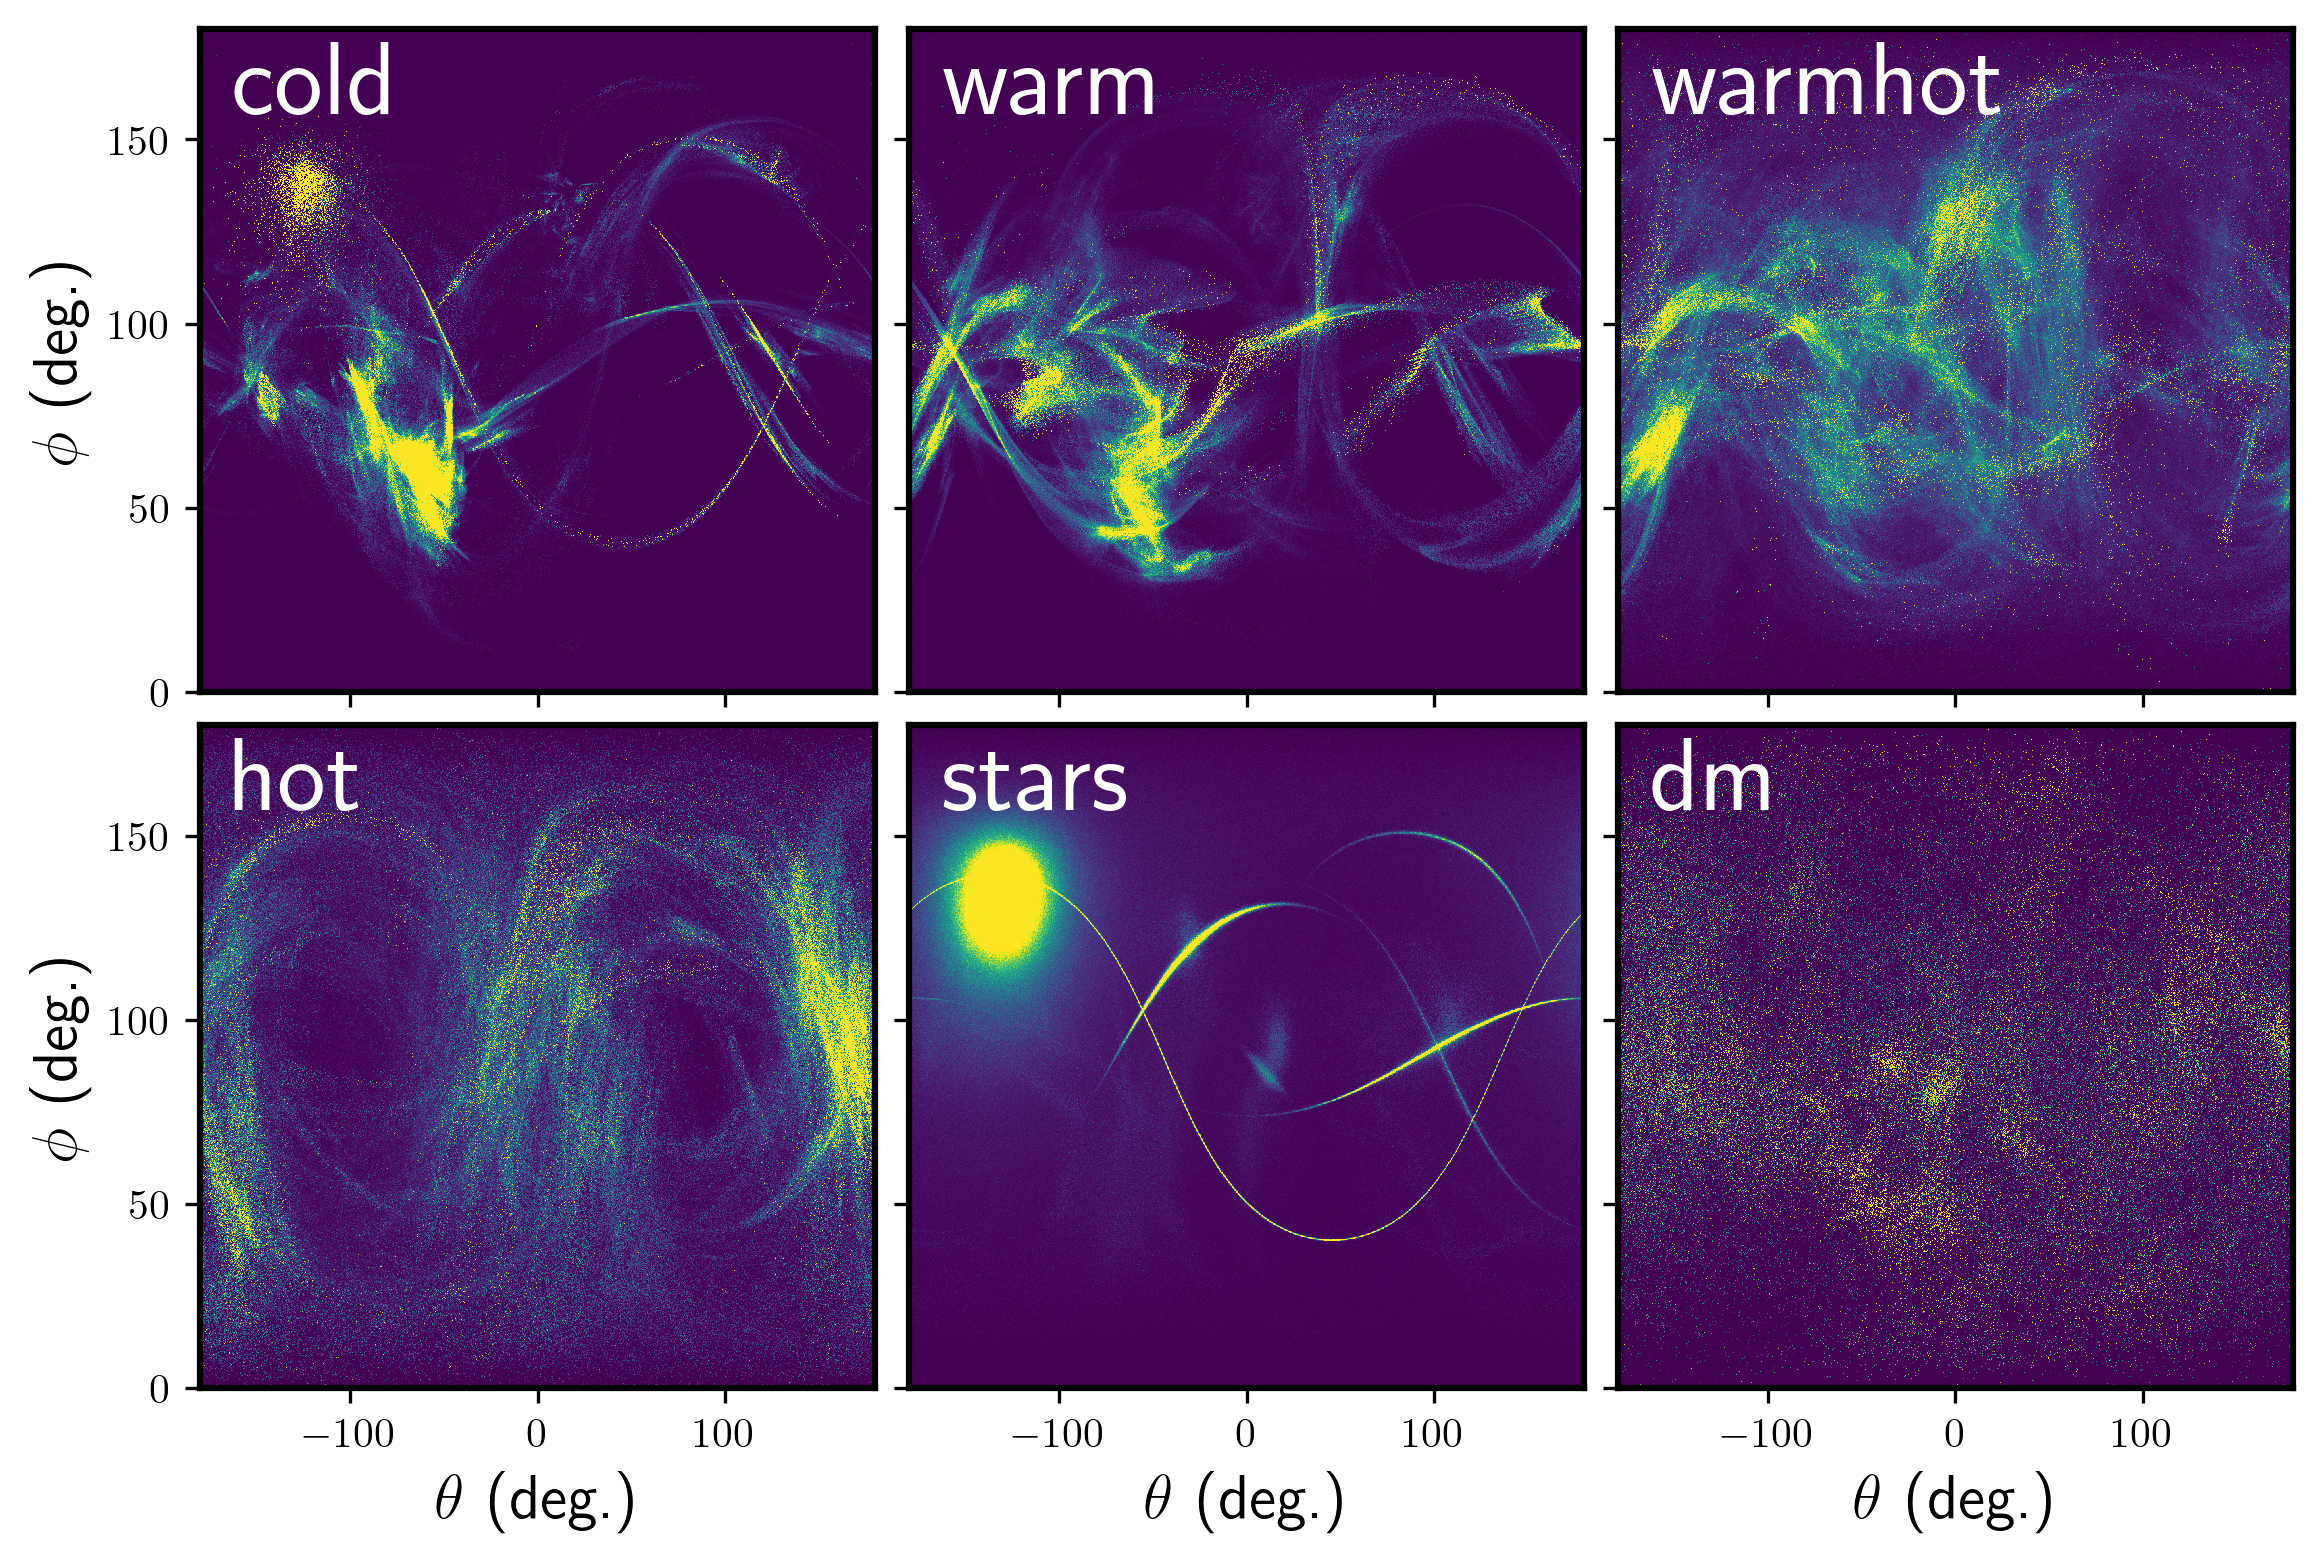

In [37]:
plt.close('all')
fig1, axes = plt.subplots(2,3, figsize = (9, 6))

for nn, name in enumerate(L_all.keys()):
    ax1 = axes.ravel()[nn]
    nbins = 1000

    xvar, xmn, xmx, xlbl =           L_all[name]['theta'], -180, 180, r'$\theta$ (deg.)'
    yvar, ymn, ymx, ylbl =           L_all[name]['phi'], 0, 180, r'$\phi$ (deg.)'

    weights = L_all[name]['L_tot']
    cmap = plt.cm.viridis
    binsx = np.linspace(xmn, xmx, nbins)
    binsy = np.linspace(ymn, ymx, nbins)

    hst = histogram2d(xvar, yvar, nbins, [[xmn, xmx], [ymn, ymx]], weights = weights)[0]
    vmin, vmax = np.percentile(hst.ravel(), [2, 98])
    ax1.hist2d(xvar, yvar, bins = [binsx, binsy], \
              norm = matplotlib.colors.Normalize(vmin, vmax),\
              weights = weights, cmap = cmap)
    ax1.annotate(name, (0.05, 0.98), xycoords = 'axes fraction', ha = 'left', va = 'top', \
                color = 'white', fontweight = 'bold', fontsize = 25)
    #ax1.axhline(y = 90, linestyle = '--', color = 'black')

for ax in axes[:,0]:
    ax.set_ylabel(ylbl)
for ax in axes[:,1:].ravel():
    ax.set_yticklabels([''])
    
for ax in axes[1]:
    ax.set_xlabel(xlbl)
for ax in axes[0].ravel():
    ax.set_xticklabels([''])
    
fig1.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig1.set_dpi(300)

In [32]:
xvar.max()

unyt_quantity(179.99979946, '(dimensionless)')

In [94]:
np.array([np.dot(L_arr[:,i], L)/L_tot[i] for i in np.arange(len(L_arr[0]))])

KeyboardInterrupt: 

In [28]:
np.arctan2?

In [65]:
import scipy
scipy.__version__

'1.5.2'